# Explainable AI SHAP and LIME Implementation for Diabetes 

## Importing Required Libraries


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from lime import lime_tabular
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

## Reading and Exploring the Dataset
### Data Processing


In [441]:
# Read the dataset
df = pd.read_csv('/Users/zarakali/Downloads/diabetes.csv')


In [443]:
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows of the dataset:")
print(df.head())

Dataset Shape: (768, 9)

First 5 rows of the dataset:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [445]:
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [447]:
print("\nNumber of zeros in each column:")
for column in df.columns:
    print(f"{column}: {(df[column] == 0).sum()}")


Number of zeros in each column:
Pregnancies: 111
Glucose: 5
BloodPressure: 35
SkinThickness: 227
Insulin: 374
BMI: 11
DiabetesPedigreeFunction: 0
Age: 0
Outcome: 500


In [449]:
print("\nBasic statistics of the dataset:")
print(df.describe())


Basic statistics of the dataset:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
m

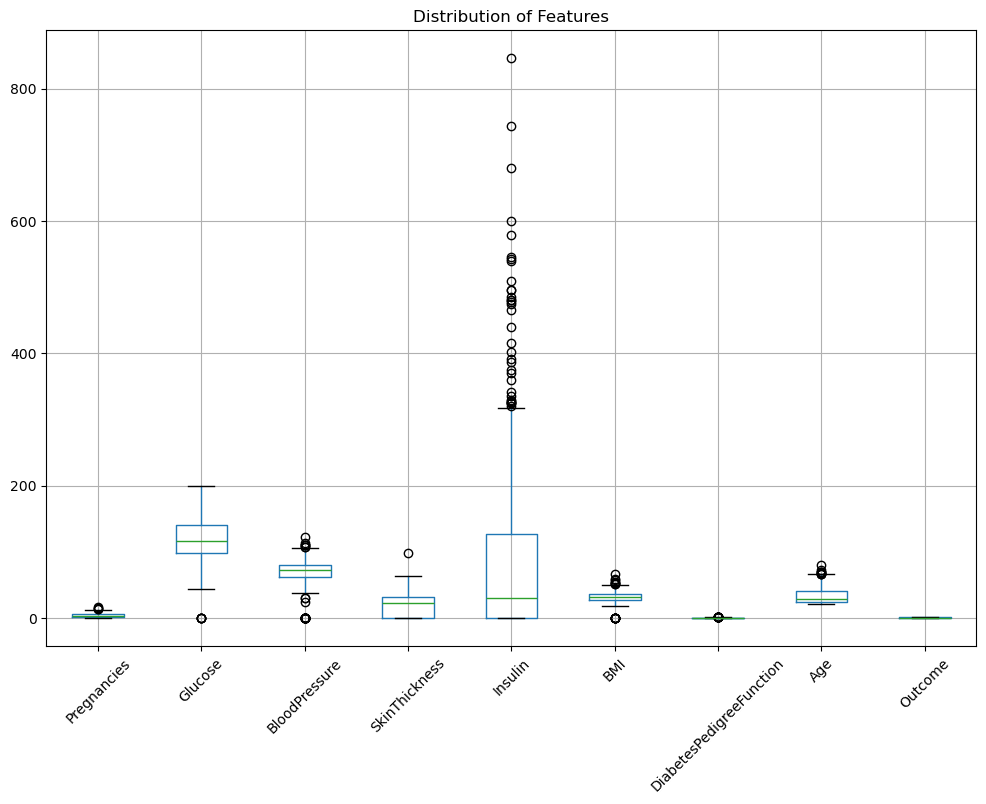

In [451]:
plt.figure(figsize=(12, 8))
df.boxplot()
plt.title('Distribution of Features')
plt.xticks(rotation=45)
plt.show()

# Feature Engineering

## Step 1: Handle Missing Values
- Replace inappropriate zero values with NaN
- Fill missing values with median
- Visualize the changes

## Step 2: Handle Outliers
- Identify outliers using IQR method
- Cap outliers at upper and lower bounds

## Step 3: Create New Features
- Create BMI categories
- Create Age groups
- Create Glucose level categories

## Step 4: Scale Features
- Standardize all features

# Feature Engineering Implementation

## Step 1: Handle Missing Values (Medically Invalid Zeros)

In [453]:
def handle_missing_values(df):
    # Make a copy of the dataframe
    df_clean = df.copy()
    
    # List of columns where 0 values are medically invalid
    zero_not_allowed = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    
    # Replace 0s with NaN and then with median
    for column in zero_not_allowed:
        # Replace 0s with NaN
        df_clean[column] = df_clean[column].replace(0, np.NaN)
        # Replace NaN with median
        median_value = df_clean[column].median()
        df_clean[column] = df_clean[column].fillna(median_value)
    
    return df_clean

In [455]:
# Apply the function
df_clean = handle_missing_values(df)

In [457]:
# Verify the changes
print("Before and After Cleaning Comparison:")
for column in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    print(f"\n{column}:")
    print(f"Original zeros: {(df[column] == 0).sum()}")
    print(f"After cleaning zeros: {(df_clean[column] == 0).sum()}")
    print(f"Original median: {df[column].median()}")
    print(f"New median: {df_clean[column].median():.2f}")

Before and After Cleaning Comparison:

Glucose:
Original zeros: 5
After cleaning zeros: 0
Original median: 117.0
New median: 117.00

BloodPressure:
Original zeros: 35
After cleaning zeros: 0
Original median: 72.0
New median: 72.00

SkinThickness:
Original zeros: 227
After cleaning zeros: 0
Original median: 23.0
New median: 29.00

Insulin:
Original zeros: 374
After cleaning zeros: 0
Original median: 30.5
New median: 125.00

BMI:
Original zeros: 11
After cleaning zeros: 0
Original median: 32.0
New median: 32.30


# Data Visualization Code

## Box Plot Comparison

### Figure Setup

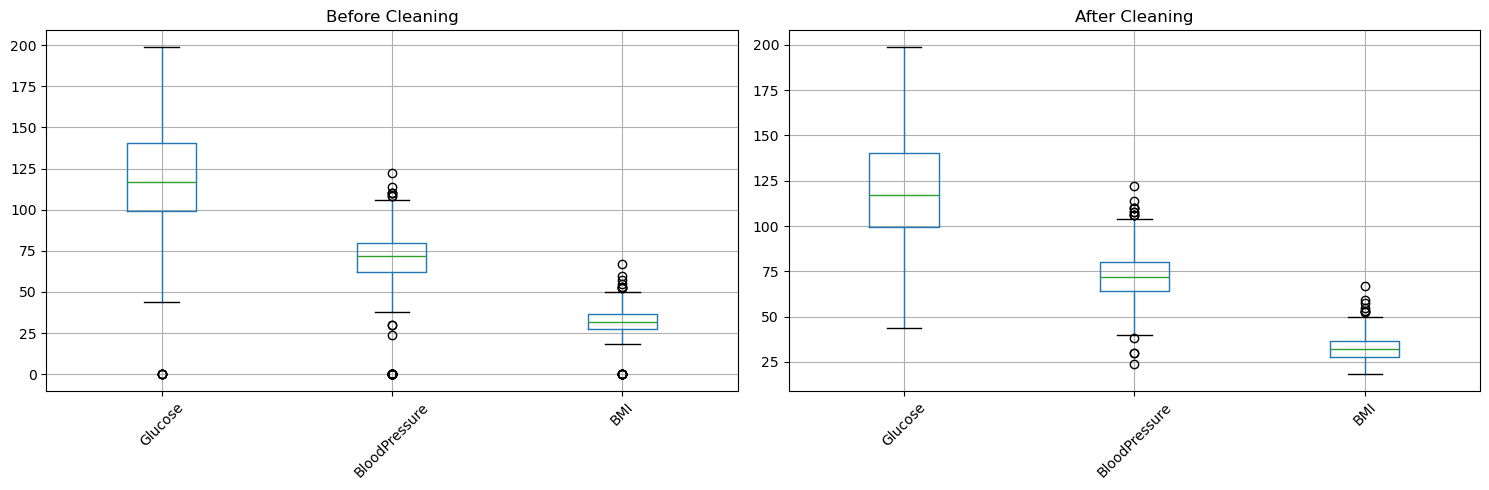

In [459]:
# Visualize the changes
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
df[['Glucose', 'BloodPressure', 'BMI']].boxplot()
plt.title('Before Cleaning')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
df_clean[['Glucose', 'BloodPressure', 'BMI']].boxplot()
plt.title('After Cleaning')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Step 2: Handle Outliers
- Using IQR method to detect outliers
- Capping outliers at upper and lower bounds

In [462]:
# Function to handle outliers (same as before)
def handle_outliers(df):
    df_out = df.copy()
    
    # Handle outliers for all columns except 'Outcome'
    for column in df_out.columns[:-1]:
        # Calculate Q1, Q3, and IQR
        Q1 = df_out[column].quantile(0.25)
        Q3 = df_out[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Calculate upper and lower bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Cap the outliers
        df_out[column] = df_out[column].clip(lower=lower_bound, upper=upper_bound)
    
    return df_out

In [464]:
# Apply outlier handling
df_clean_no_outliers = handle_outliers(df_clean)


# Data Visualization Code

## Subplot Configuration

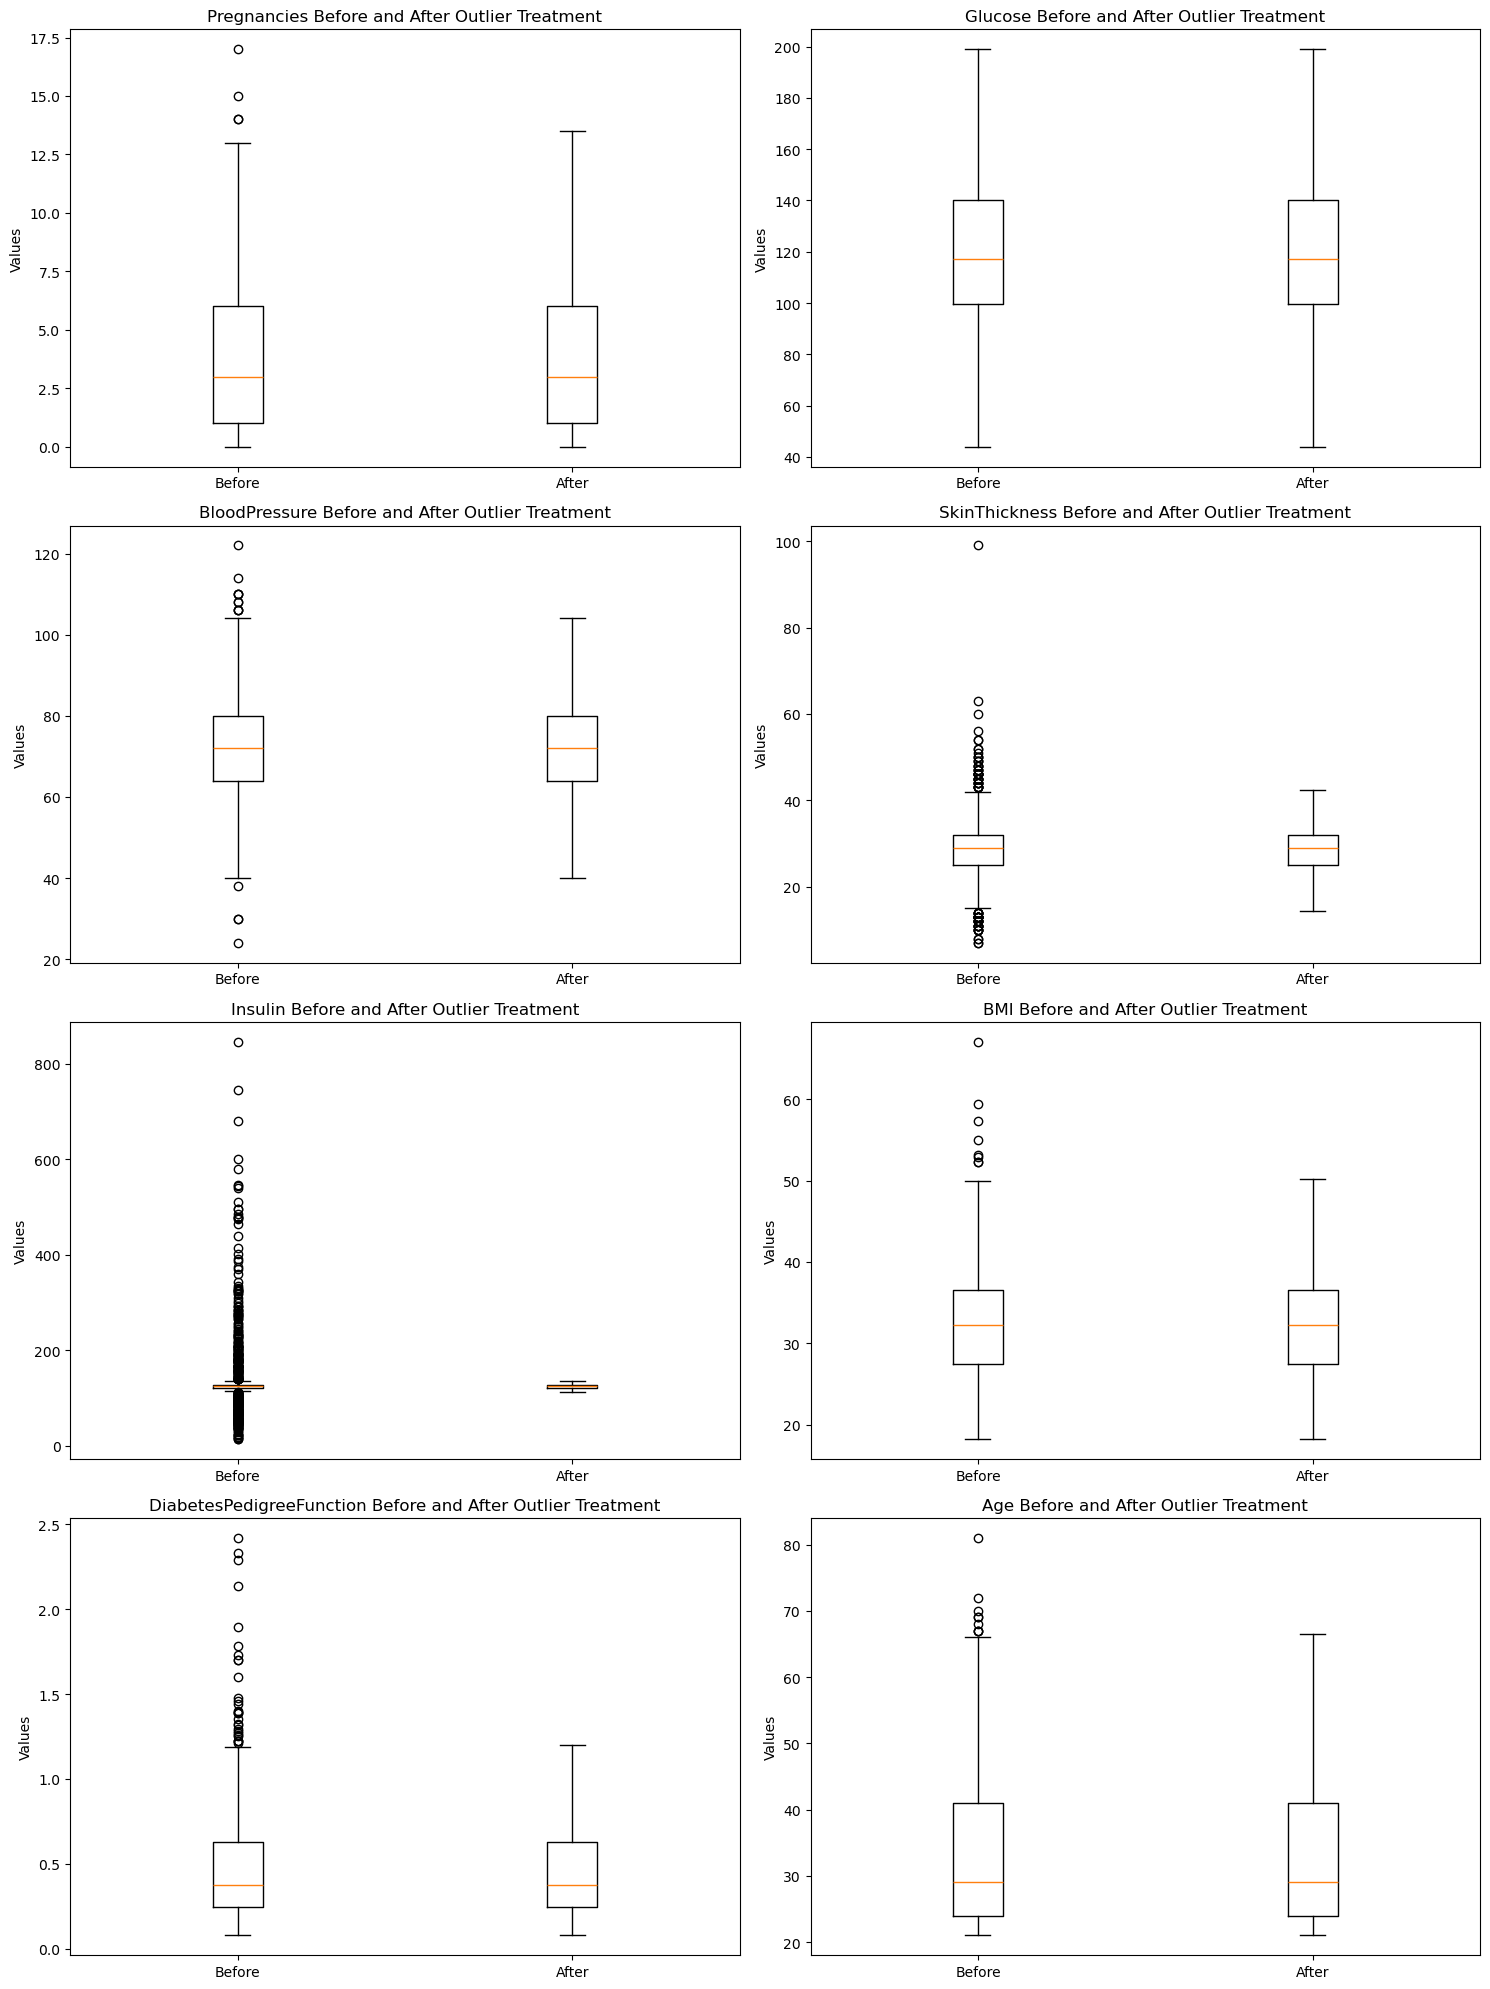

In [466]:
# Create subplots for each feature
features = df_clean.columns[:-1]  # All columns except 'Outcome'
n_features = len(features)
n_rows = (n_features + 1) // 2  # Calculate number of rows needed

plt.figure(figsize=(15, 5*n_rows))

for idx, feature in enumerate(features, 1):
    # Create subplot for each feature
    plt.subplot(n_rows, 2, idx)
    
    # Create box plots with updated parameter name
    plt.boxplot([df_clean[feature], df_clean_no_outliers[feature]], 
                tick_labels=['Before', 'After'])  # Changed 'labels' to 'tick_labels'
    plt.title(f'{feature} Before and After Outlier Treatment')
    plt.ylabel('Values')

plt.tight_layout()
plt.show()

In [468]:
# Print summary of changes
for column in features:
    print(f"\n{column}:")
    print(f"Before - min: {df_clean[column].min():.2f}, max: {df_clean[column].max():.2f}")
    print(f"After  - min: {df_clean_no_outliers[column].min():.2f}, max: {df_clean_no_outliers[column].max():.2f}")


Pregnancies:
Before - min: 0.00, max: 17.00
After  - min: 0.00, max: 13.50

Glucose:
Before - min: 44.00, max: 199.00
After  - min: 44.00, max: 199.00

BloodPressure:
Before - min: 24.00, max: 122.00
After  - min: 40.00, max: 104.00

SkinThickness:
Before - min: 7.00, max: 99.00
After  - min: 14.50, max: 42.50

Insulin:
Before - min: 14.00, max: 846.00
After  - min: 112.88, max: 135.88

BMI:
Before - min: 18.20, max: 67.10
After  - min: 18.20, max: 50.25

DiabetesPedigreeFunction:
Before - min: 0.08, max: 2.42
After  - min: 0.08, max: 1.20

Age:
Before - min: 21.00, max: 81.00
After  - min: 21.00, max: 66.50


## Step 3: Create New Features
- Create BMI Categories (based on WHO standards)
- Create Age Groups
- Create Glucose Level Categories (based on medical standards)

In [471]:
def create_features(df):
    # Make a copy of the dataframe
    df_new = df.copy()
    
    # Create BMI Categories
    df_new['BMI_Category'] = pd.cut(df_new['BMI'], 
                                   bins=[-float('inf'), 18.5, 24.9, 29.9, float('inf')],
                                   labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
    
    # Create Age Groups
    df_new['Age_Group'] = pd.cut(df_new['Age'], 
                                bins=[0, 20, 40, 60, float('inf')],
                                labels=['0-20', '21-40', '41-60', '60+'])
    
    # Create Glucose Level Categories
    df_new['Glucose_Category'] = pd.cut(df_new['Glucose'], 
                                       bins=[-float('inf'), 70, 99, 126, float('inf')],
                                       labels=['Low', 'Normal', 'Pre-diabetes', 'Diabetes'])
    
    # Convert categorical variables to dummy variables
    df_new = pd.get_dummies(df_new, columns=['BMI_Category', 'Age_Group', 'Glucose_Category'])
    
    return df_new

In [567]:
# Apply feature creation
df_featured = create_features(df_clean_no_outliers)

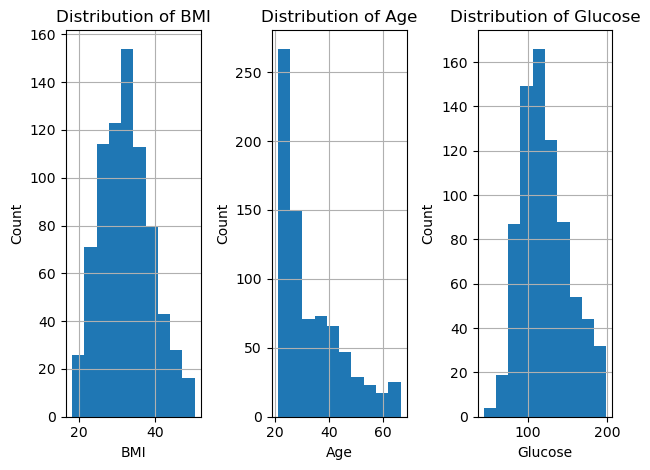

In [569]:
# Plot distribution of original features with new categories
features_to_plot = ['BMI', 'Age', 'Glucose']
for idx, feature in enumerate(features_to_plot, 1):
    plt.subplot(1, 3, idx)
    df_featured[feature].hist()
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Step 4: Scale Features
- Standardize numerical features
- Prepare data for model training

In [480]:
# Separate features for scaling (exclude dummy variables and target)
numeric_features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [482]:
# Initialize the scaler
scaler = StandardScaler()


In [484]:
# Fit and transform numeric features
df_featured[numeric_features] = scaler.fit_transform(df_featured[numeric_features])


In [486]:
# Verify scaling results
print("After scaling - Numeric Features Statistics:")
print(df_featured[numeric_features].describe())

After scaling - Numeric Features Statistics:
        Pregnancies       Glucose  BloodPressure  SkinThickness       Insulin  \
count  7.680000e+02  7.680000e+02   7.680000e+02   7.680000e+02  7.680000e+02   
mean  -6.938894e-17  4.625929e-18  -3.827956e-16   1.734723e-16 -5.944319e-16   
std    1.000652e+00  1.000652e+00   1.000652e+00   1.000652e+00  1.000652e+00   
min   -1.148194e+00 -2.552931e+00  -2.768136e+00  -1.931634e+00 -1.494110e+00   
25%   -8.489700e-01 -7.201630e-01  -7.150082e-01  -5.198700e-01 -4.035031e-01   
50%   -2.505221e-01 -1.530732e-01  -3.063207e-02   1.794466e-02  3.906197e-02   
75%    6.471497e-01  6.112653e-01   6.537440e-01   4.213057e-01  3.235681e-01   
max    2.891329e+00  2.542658e+00   2.706872e+00   1.833069e+00  1.414175e+00   

                BMI  DiabetesPedigreeFunction           Age  
count  7.680000e+02              7.680000e+02  7.680000e+02  
mean  -4.417762e-16             -2.081668e-16  2.220446e-16  
std    1.000652e+00              1.0006

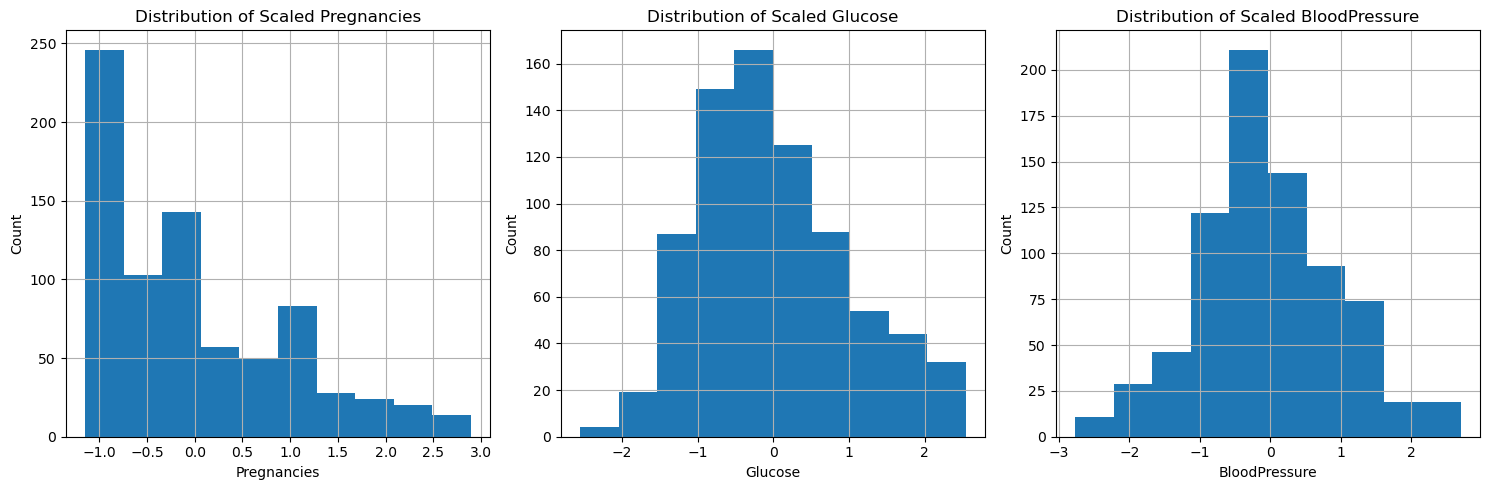

In [488]:
# Visualize scaled features
plt.figure(figsize=(15, 5))
for idx, feature in enumerate(numeric_features[:3], 1):  # Plotting first 3 features as example
    plt.subplot(1, 3, idx)
    df_featured[feature].hist()
    plt.title(f'Distribution of Scaled {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Model Implementation: Random Forest
1. Split the data into training and testing sets
2. Create and train Random Forest model
3. Evaluate model performance

In [493]:
# 2. Split data first
X = df_featured.drop('Outcome', axis=1)
y = df_featured['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [495]:
# 3. Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


In [497]:
# 4. Train model with balanced data
rf_model = RandomForestClassifier(
    n_estimators=200,           # Number of trees
    max_depth=10,               # Maximum depth of trees
    min_samples_split=5,        # Minimum samples before splitting
    min_samples_leaf=2,         # Minimum samples in leaf nodes
    class_weight='balanced',    # Account for class imbalance
    random_state=42
)

In [499]:
# 5. Fit the model
rf_model.fit(X_train_balanced, y_train_balanced)


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)

In [501]:
# 6. Make predictions
y_pred = rf_model.predict(X_test)


In [503]:
# 7. Print results
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Accuracy: 0.7987012987012987

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.79      0.83        99
           1       0.68      0.82      0.74        55

    accuracy                           0.80       154
   macro avg       0.78      0.80      0.79       154
weighted avg       0.81      0.80      0.80       154



In [505]:
# 8. Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})

In [507]:
# 9. Sort features by importance
feature_importance = feature_importance.sort_values('importance', ascending=False)


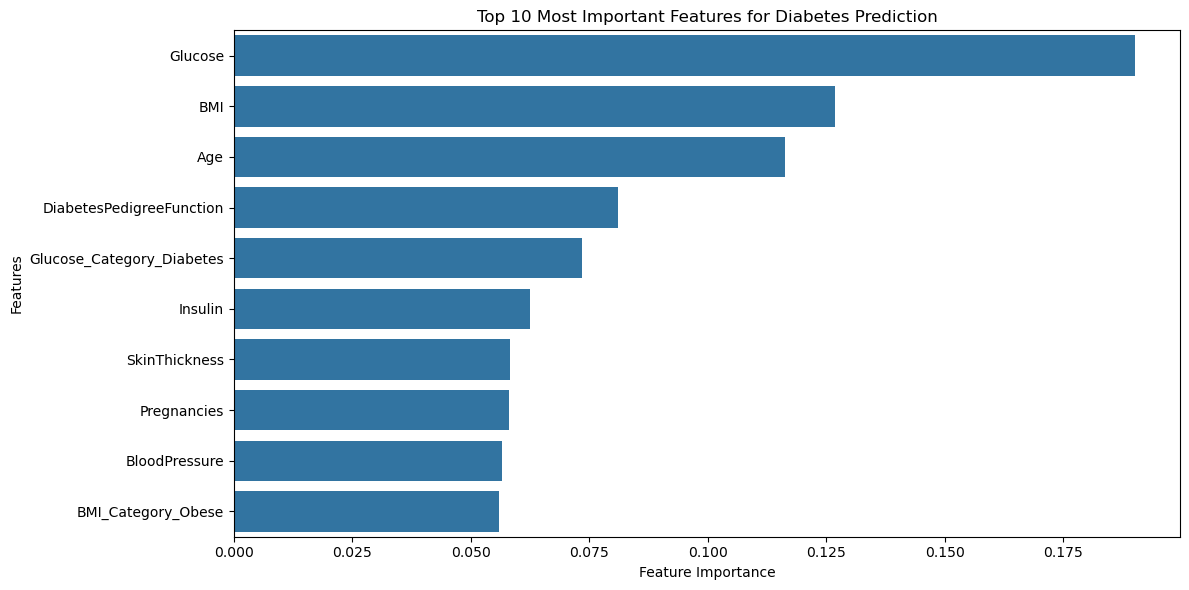

In [509]:
# 10. Visualize top 10 features
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features for Diabetes Prediction')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [511]:
# 11. Print numeric values
print("\nFeature Importance Scores:")
print(feature_importance.head(10))


Feature Importance Scores:
                      feature  importance
1                     Glucose    0.190094
5                         BMI    0.126713
7                         Age    0.116180
6    DiabetesPedigreeFunction    0.081039
19  Glucose_Category_Diabetes    0.073423
4                     Insulin    0.062468
3               SkinThickness    0.058154
0                 Pregnancies    0.057954
2               BloodPressure    0.056520
11         BMI_Category_Obese    0.055886


# Model Evaluation: Confusion Matrix
This visualization shows the model's prediction performance:
- True Positives and True Negatives (correct predictions)
- False Positives and False Negatives (incorrect predictions)

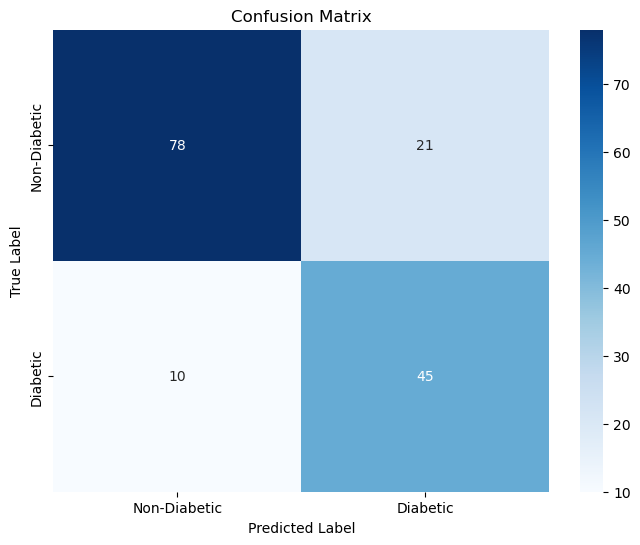

In [514]:
def plot_confusion_matrix():
    """
    Plot confusion matrix for model evaluation
    """
    # Get predictions
    y_pred = rf_model.predict(X_test)
    
    # Create and plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Diabetic', 'Diabetic'],
                yticklabels=['Non-Diabetic', 'Diabetic'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Run confusion matrix plot
plot_confusion_matrix()

# Model Evaluation: ROC Curve
This visualization shows the model's discriminative ability:
- ROC (Receiver Operating Characteristic) curve
- AUC (Area Under the Curve) score
- Trade-off between True Positive Rate and False Positive Rate

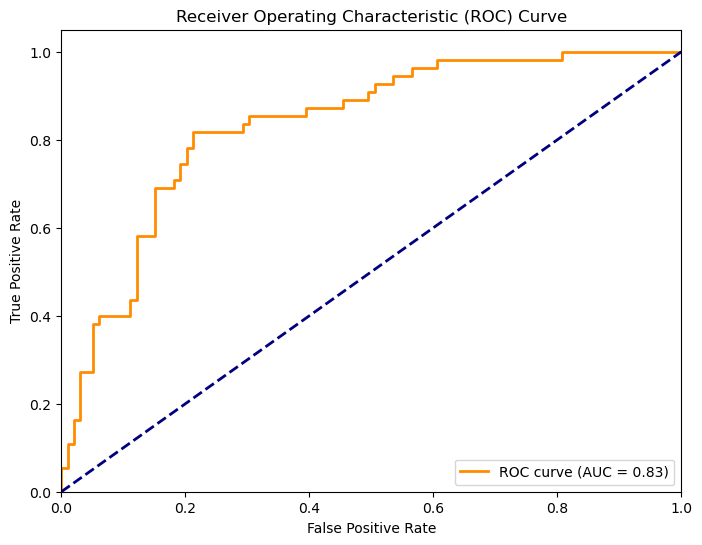

In [517]:
def plot_roc_curve():
    """
    Plot ROC curve for model evaluation
    """
    # Get prediction probabilities
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Run ROC curve plot
plot_roc_curve()

# Model Evaluation: Cross-Validation Analysis
This analysis performs 5-fold cross-validation to assess model stability and performance:
- Splits data into 5 different train/validation sets
- Shows model performance for each fold
- Visualizes results across all folds through a line plot

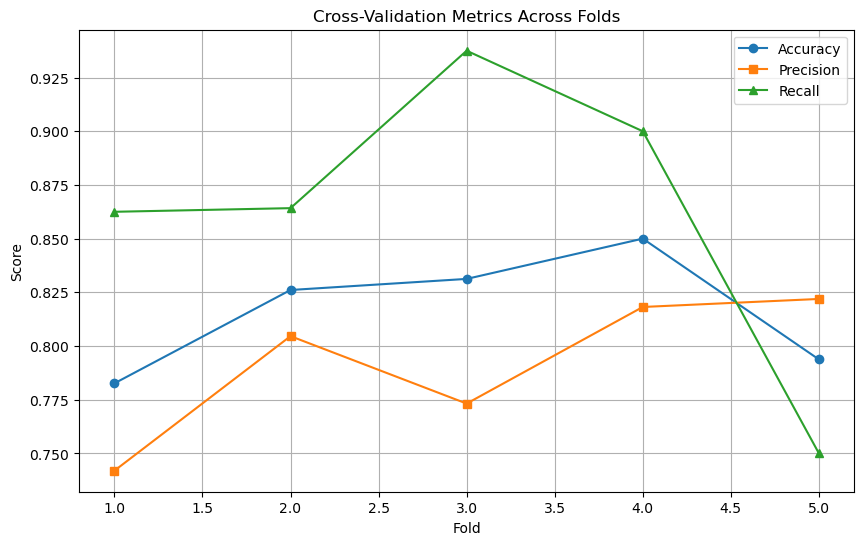

In [608]:
def perform_cross_validation():
    """
    Perform 5-fold cross-validation with detailed metrics for each fold
    """
    # Initialize StratifiedKFold for 5 splits
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
    # StratifiedKFold ensures class distribution is preserved in each fold

    # Initialize a list to store metrics for each fold
    fold_metrics = []  

    # Perform k-fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_balanced, y_train_balanced), 1):
        # Split data into training and validation sets for this fold
        X_fold_train = X_train_balanced.iloc[train_idx]  # Training features for this fold
        y_fold_train = y_train_balanced.iloc[train_idx]  # Training labels for this fold
        X_fold_val = X_train_balanced.iloc[val_idx]  # Validation features for this fold
        y_fold_val = y_train_balanced.iloc[val_idx]  # Validation labels for this fold

        # Initialize a Random Forest Classifier with hyperparameters
        fold_model = RandomForestClassifier(
            n_estimators=200,  # Number of trees in the forest
            max_depth=10,  # Maximum depth of the trees
            min_samples_split=5,  # Minimum samples required to split an internal node
            min_samples_leaf=2,  # Minimum samples required to be at a leaf node
            class_weight='balanced',  # Adjust weights to handle class imbalance
            random_state=42  # Seed for reproducibility
        )

        # Train the model on the training set for this fold
        fold_model.fit(X_fold_train, y_fold_train)

        # Make predictions on the validation set
        y_fold_pred = fold_model.predict(X_fold_val)

        # Calculate evaluation metrics for this fold
        fold_accuracy = accuracy_score(y_fold_val, y_fold_pred)  # Accuracy metric
        fold_precision = precision_score(y_fold_val, y_fold_pred)  # Precision metric
        fold_recall = recall_score(y_fold_val, y_fold_pred)  # Recall metric

        # Store metrics for this fold
        fold_metrics.append({
            'Fold': fold,  # Fold number
            'Accuracy': fold_accuracy,  # Accuracy score
            'Precision': fold_precision,  # Precision score
            'Recall': fold_recall  # Recall score
        })

    # Convert the collected metrics into a DataFrame for easier analysis
    metrics_df = pd.DataFrame(fold_metrics)

    # Visualize the cross-validation results using a line plot
    plt.figure(figsize=(10, 6))  # Set figure size for better visibility

    # Plot Accuracy, Precision, and Recall for each fold
    plt.plot(metrics_df['Fold'], metrics_df['Accuracy'], 'o-', label='Accuracy')  # Plot Accuracy
    plt.plot(metrics_df['Fold'], metrics_df['Precision'], 's-', label='Precision')  # Plot Precision
    plt.plot(metrics_df['Fold'], metrics_df['Recall'], '^-', label='Recall')  # Plot Recall

    # Add plot title and labels
    plt.title('Cross-Validation Metrics Across Folds')  # Plot title
    plt.xlabel('Fold')  # X-axis label
    plt.ylabel('Score')  # Y-axis label

    # Add legend to differentiate metrics
    plt.legend()

    # Add grid for better readability
    plt.grid(True)

    # Display the plot
    plt.show()

# Run cross-validation analysis
perform_cross_validation()


# LIME Implementation
1. Set up LIME explainer
2. Explain individual predictions
3. Visualize LIME explanations

In [571]:
# Initialize the LimeTabularExplainer for explaining individual predictions
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train_balanced.values,  # The training data (balanced) converted to NumPy array for LIME
    feature_names=X_train_balanced.columns,  # Names of the features in the dataset
    class_names=['Non-Diabetic', 'Diabetic'],  # Names of the target classes for interpretability
    mode='classification',  # Specify the type of problem (classification or regression)
    random_state=42  # Set a random state for reproducibility of explanations
)


In [573]:
#  Explanation function
def explain_prediction(instance, true_label):
    # Check if the input instance is a Pandas Series
    # Convert it into a DataFrame with a single row to retain feature names
    if isinstance(instance, pd.Series):
        instance_df = pd.DataFrame([instance])  # Convert Series to DataFrame
    else:
        instance_df = pd.DataFrame([instance], columns=X_train.columns)  # Ensure column names are preserved

    # Define a wrapper function for predict_proba to include feature names
    def predict_proba_with_names(input_data):
        # Convert input_data (NumPy array) into a DataFrame with feature names
        input_df = pd.DataFrame(input_data, columns=X_train.columns)
        return rf_model.predict_proba(input_df)  # Predict probabilities using the random forest model
    
    # Use the LIME explainer to explain the instance
    exp = explainer.explain_instance(
        instance_df.values[0],  # Instance to explain, converted to NumPy array
        predict_proba_with_names,  # Model's predict_proba function wrapped to retain feature names
        num_features=10  # Number of features to display in the explanation
    )
    
    # Get the model's prediction for the instance
    prediction = rf_model.predict(instance_df)[0]  # Predicted class (e.g., 0 or 1)
    prediction_prob = rf_model.predict_proba(instance_df)[0]  # Probabilities for each class
    
    # Print the true and predicted labels for the instance
    print(f"True Label: {'Diabetic' if true_label == 1 else 'Non-Diabetic'}")
    print(f"Predicted Label: {'Diabetic' if prediction == 1 else 'Non-Diabetic'}")
    print(f"Prediction Probability: {prediction_prob[1]:.2f}")  # Probability for the 'Diabetic' class
    
    exp.show_in_notebook()  # Visualizes the explanation for the prediction
    
    return exp  # Return the explanation object


In [575]:
# Select the first instance from the test set for explanation
example_idx = 0  # Index of the instance to explain
instance_to_explain = X_test.iloc[example_idx]  # Retrieve the feature values of the instance
true_label = y_test.iloc[example_idx]  # Retrieve the true label (ground truth) of the instance

# Print the heading for the explanation
print("Example Prediction Explanation:")

# Call the `explain_prediction` function to explain the selected instance
exp = explain_prediction(instance_to_explain, true_label)


Example Prediction Explanation:
True Label: Non-Diabetic
Predicted Label: Non-Diabetic
Prediction Probability: 0.49


<Figure size 1000x600 with 0 Axes>

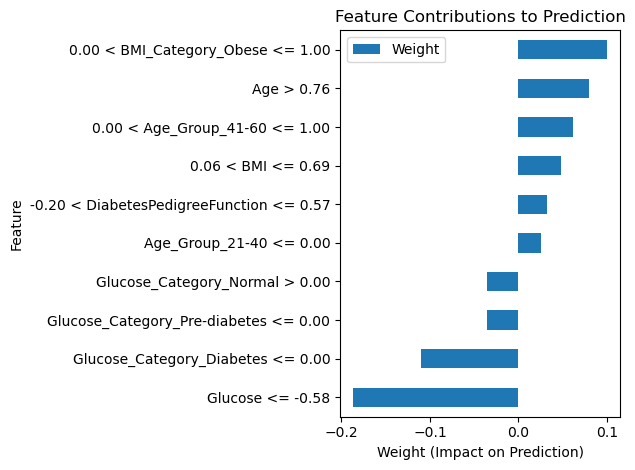

In [577]:
# Convert the explanation results to a DataFrame
feature_weights = pd.DataFrame(
    exp.as_list(),  # Extract the list of feature contributions from the LIME explanation
    columns=['Feature', 'Weight']  # Define column names: 'Feature' and 'Weight'
).sort_values('Weight', ascending=True)  # Sort the DataFrame by 'Weight' in ascending order

# Plotting the feature contributions
plt.figure(figsize=(10, 6))  # Set the size of the plot
feature_weights.plot(x='Feature', y='Weight', kind='barh')  # Create a horizontal bar plot
plt.title('Feature Contributions to Prediction')  # Add a title to the plot
plt.xlabel('Weight (Impact on Prediction)')  # Label the x-axis
plt.tight_layout()  # Adjust the layout to prevent overlap of elements
plt.show()  # Display the plot


In [581]:
# Initialize an empty list to store indices of correctly predicted diabetic cases
correct_diabetic_indices = []

# Iterate through all test set instances
for i in range(len(y_test)):
    true_label = y_test.iloc[i]  # Get the true label for the current instance
    
    # Convert the instance to a DataFrame to maintain feature names during prediction
    test_instance = pd.DataFrame([X_test.iloc[i]], columns=X_test.columns)
    
    # Get the model's predicted label for the current instance
    predicted_label = rf_model.predict(test_instance)[0]
    
    # Check if both the true label and predicted label are diabetic (1)
    if true_label == 1 and predicted_label == 1:
        correct_diabetic_indices.append(i)  # Add the index to the list

# Take the first correct diabetic case for explanation
example_idx = correct_diabetic_indices[0]  # Retrieve the first correctly classified diabetic case index

# Create a proper DataFrame for the instance
instance_to_explain = pd.DataFrame([X_test.iloc[example_idx]], columns=X_test.columns)  # Prepare the instance as a DataFrame
true_label = y_test.iloc[example_idx]  # Retrieve the true label for the selected instance

# Print a heading for the explanation
print("Example Prediction Explanation (Correctly Predicted Diabetic Case):")

# Call the explain_prediction function to analyze the selected instance
exp = explain_prediction(instance_to_explain.iloc[0], true_label)


Example Prediction Explanation (Correctly Predicted Diabetic Case):
True Label: Diabetic
Predicted Label: Diabetic
Prediction Probability: 0.56


<Figure size 1000x600 with 0 Axes>

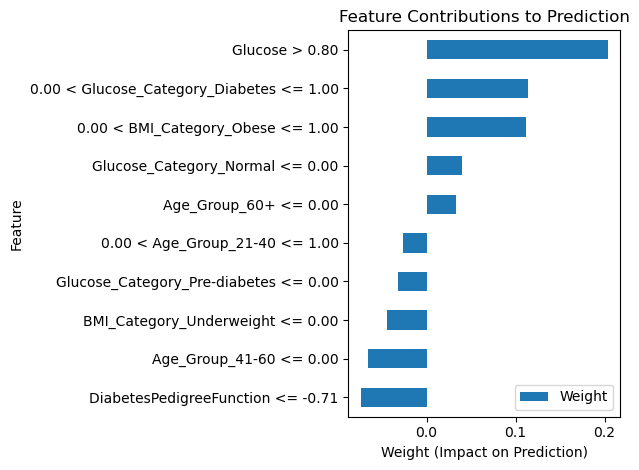

In [583]:
# Convert LIME explanation results to a DataFrame
feature_weights = pd.DataFrame(
    exp.as_list(),  # Extracts the list of feature contributions (Feature-Weight pairs) from the LIME explanation
    columns=['Feature', 'Weight']  # Define column names for the DataFrame
).sort_values('Weight', ascending=True)  # Sort the DataFrame by 'Weight' in ascending order

# Plotting the feature contributions
plt.figure(figsize=(10, 6))  # Set the size of the figure
feature_weights.plot(x='Feature', y='Weight', kind='barh')  # Create a horizontal bar plot for feature contributions
plt.title('Feature Contributions to Prediction')  # Add a title to the plot
plt.xlabel('Weight (Impact on Prediction)')  # Label the x-axis to indicate feature impact
plt.tight_layout()  # Adjust the layout to prevent overlapping of labels and elements
plt.show()  # Display the plot


# SHAP Analysis for Random Forest Model
1. Set up SHAP explainer
2. SHAP Values help understand feature importance for predictions
3. Test Dataset is used to generate comprehensive model interpretations

In [585]:
# Create a SHAP explainer for the Random Forest model
shap_explainer = shap.TreeExplainer(rf_model)  
# `TreeExplainer` is optimized for tree-based models like Random Forest, Gradient Boosting, etc.
# It efficiently calculates SHAP values by leveraging the tree structure of the model.

# Calculate SHAP values for the test dataset
shap_values = shap_explainer.shap_values(X_test)  
# SHAP values quantify the contribution of each feature to the model's prediction for every test instance.
# `shap_values` is a list with one element for each class in the model (e.g., Non-Diabetic, Diabetic).


In [587]:
# Extract the correct SHAP values for the positive class
shap_values_positive = shap_values[:, :, 1]  # Extract SHAP values for the positive class (index 1)

# SHAP Bar Plot Visualization
## Understanding Feature Importance


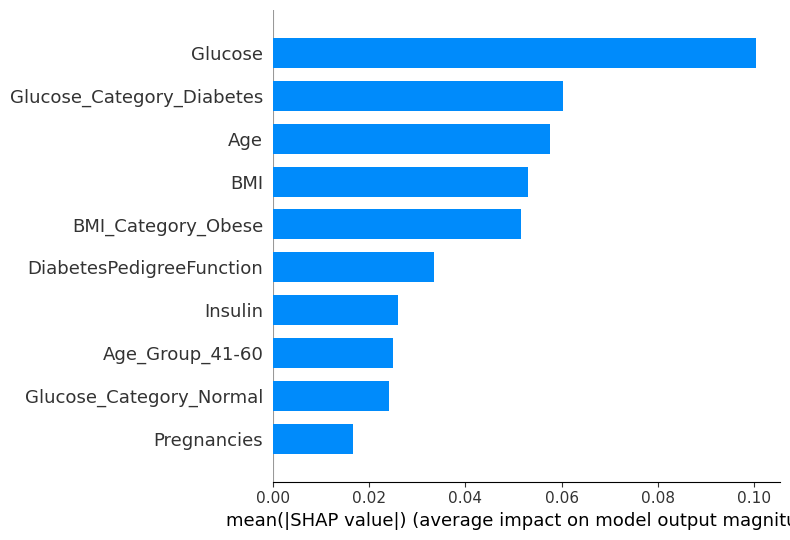

In [589]:
# Generate a SHAP bar plot
shap.summary_plot(
    shap_values_positive,  # SHAP values for the positive class (e.g., 'Diabetic')
    X_test,  # Test dataset used for SHAP value calculations
    feature_names=X_test.columns,  # Display feature names on the y-axis
    plot_type='bar',  # Create a bar plot to show global feature importance
    max_display=10  # Limit the plot to the top 10 most important features
)


# SHAP Dependence Plot Analysis
## Feature Interaction Visualization


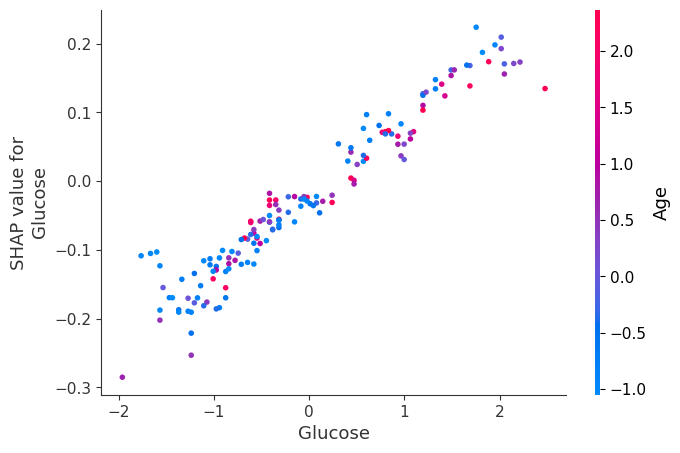

In [591]:
# Generate a SHAP Dependence plot for a specific feature

dependence_feature = 'Glucose'  # Specify the feature for which the dependence plot will be created

shap.dependence_plot(
    dependence_feature,  # The feature to analyze for dependence
    shap_values_positive,  # SHAP values for the positive class (e.g., 'Diabetic')
    X_test,  # Test dataset used for SHAP value calculations
    feature_names=X_test.columns  # Display feature names for interpretability
)


# SHAP Force Plot Visualization
## Individual Prediction Breakdown


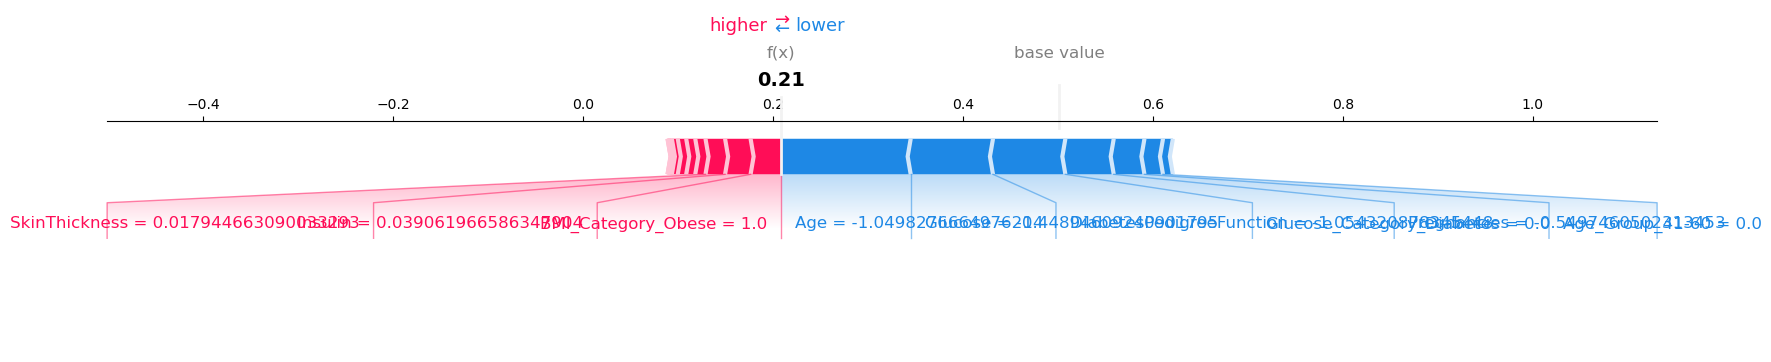

In [610]:
#Force Plot
i = 2  # Select the index of the instance to explain (2 = first instance in X_test)

shap.force_plot(
    shap_explainer.expected_value[1],  # The base value (expected model output for the positive class)
    shap_values_positive[i],  # SHAP values for the selected instance (positive class)
    X_test.iloc[i],  # Feature values for the selected instance
    feature_names=X_test.columns,  # Display feature names for interpretability
    matplotlib=True  # Use Matplotlib for generating the force plot as a static plot
)

plt.show()  # Display the force plot


In [ ]:
## SHAP summary plot for the negative class
shap_values_negative = shap_values[:, :, 0]  # Extract SHAP values for the negative class (index 0)
shap.summary_plot(
    shap_values_negative,
    X_test,
    feature_names=X_test.columns
)

# SHAP Summary Plot for Non-Diabetic Class
# Feature Impact Visualization


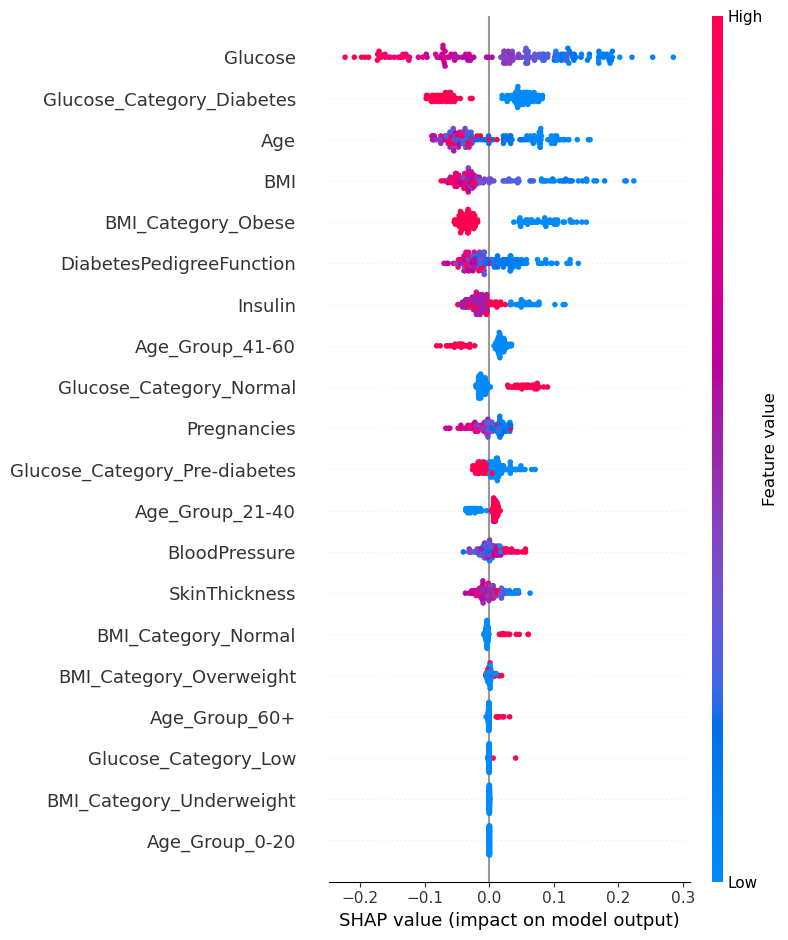

In [606]:
shap.summary_plot(
    shap_values[:, :, 0],  # SHAP values for the negative class (e.g., Non-Diabetic)
    X_test,  # Test dataset
    feature_names=X_test.columns  # Correct attribute to access column names
)


# REFRENCES
1. https://youtu.be/L8_sVRhBDLU?si=XyoKQF1Fu5nZBu1X
2. https://towardsdatascience.com/decrypting-your-machine-learning-model-using-lime-5adc035109b5
3. https://www.obviously.ai/post/data-cleaning-in-machine-learning
4. https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
5. https://towardsdatascience.com/random-forest-in-python-24d0893d51c0